# Finding Area:

In [51]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [52]:
# Parameters

# img_path = './Images/T.Angelina/I3800.png' 
img_path = './Images/X.png'

removal_method='dilation-erosion',# ["gaussian-blur", "median-blur", "bilateral-filter", "erosion-dilation]

granular_degree = 0.05

In [53]:
def removal_ct(img,removal_method):
    if(removal_method=='gaussian-blur'):
        blurred_image = cv2.GaussianBlur(img, (11, 11), 0)
        (T, thresh) = cv2.threshold(blurred_image, 155, 255, cv2.THRESH_BINARY)
        return thresh
    elif(removal_method=='median-blur'):
        blurred_image = cv2.medianBlur(img, 11)
        (T, thresh) = cv2.threshold(blurred_image, 155, 255, cv2.THRESH_BINARY)
        return thresh
    elif(removal_method=='bilateral-filter'):
        blurred_image = cv2.bilateralFilter(img, 11, 17, 17)
        (T, thresh) = cv2.threshold(blurred_image, 155, 255, cv2.THRESH_BINARY)
        return thresh
    elif(removal_method=='erosion-dilation'):
        kernel_size=3
        kernel = np.ones((kernel_size,kernel_size),np.uint8)
        erosion = cv2.erode(img,kernel,iterations = 1)
        dilation = cv2.dilate(erosion,kernel,iterations = 1)
        return dilation
    elif(removal_method=='dilation-erosion'):
        kernel_size=3
        kernel = np.ones((kernel_size,kernel_size),np.uint8)
        dilation = cv2.dilate(img,kernel,iterations = 1)
        erosion = cv2.erode(dilation,kernel,iterations = 1)
        return erosion

In [55]:
temp = []

def line_iter(start, end):
    """Yield coordinates on a line from start to end using Bresenham's algorithm."""
    x0, y0 = start
    x1, y1 = end
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        yield (x0, y0)
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

def process_ray(img, center, process_point_func):
    height, width = img.shape[:2]
    new_img = np.zeros((height, width, 3), dtype=np.uint8)  # Create a blank color image

    for angle in np.arange(0, 360, granular_degree):
        theta = np.deg2rad(angle)
        end_x = int(center[0] + math.cos(theta) * width)
        end_y = int(center[1] + math.sin(theta) * height)

        point_to_color, point_to_color2 = process_point_func(img, center, (end_x, end_y))
        temp.append(point_to_color)
        
        if point_to_color:
            new_img[point_to_color[1], point_to_color[0]] = [0, 0, 255]  # Color the point red
            new_img[point_to_color2[1], point_to_color2[0]] = [255, 0, 0]  # Color the point red

    return new_img

def find_last_point(img, start, end):
    last_black_point = None
    last_white_point = None
    answer=None
    for x, y in line_iter(start, end):
        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
            if img[y, x] == 0:
                last_black_point = (x, y)
            elif last_black_point and img[y, x] != 0:  # Check for a white point after the last black point
                answer=last_black_point
            
            if img[y,x] == 255:
                last_white_point = (x,y)
    return answer, last_white_point

def convert_to_rgb_if_grayscale(img):
    if len(img.shape) == 2 or img.shape[2] == 1:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img_rgb
    else:
        return img

def convert_to_grayscale_if_rgb(img):
    if len(img.shape) == 3 and img.shape[2] == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img_gray
    else:
        return img


# Compute area
def compute_areas(img, center, process_point_func):
    height, width = img.shape[:2]
    subcut_area = 0
    
    flag=0
    for angle in np.arange(0, 360, granular_degree):
        theta = np.deg2rad(angle)

        flag += np.deg2rad(granular_degree)  
        end_x = int(center[0] + math.cos(theta) * width)
        end_y = int(center[1] + math.sin(theta) * height)

        bk,wh = process_point_func(img, center, (end_x, end_y))
        temp.append(bk)
        if bk and wh:
            subcut_area +=  0.5*((wh[0]-center[0])**2 +  (wh[1]-center[1])**2 - (bk[0]-center[0])**2 - (bk[1]-center[1])**2) * np.deg2rad(granular_degree)
            # print(subcut_area)
    print("flag : ",flag) # should check if the metric is close to 2pi
    return subcut_area

def compute_white_area(img):

    total = 0
    for x in img:
        for y in x:
            if y==255:
                total+=1
    return total

Image Path:  ./Images/C.Vishnu/I1750.png
flag :  6.283185307179227
Subcut-area :  10093.78578867138
Total-area :  35774
Ratio :  2.5441608083411533


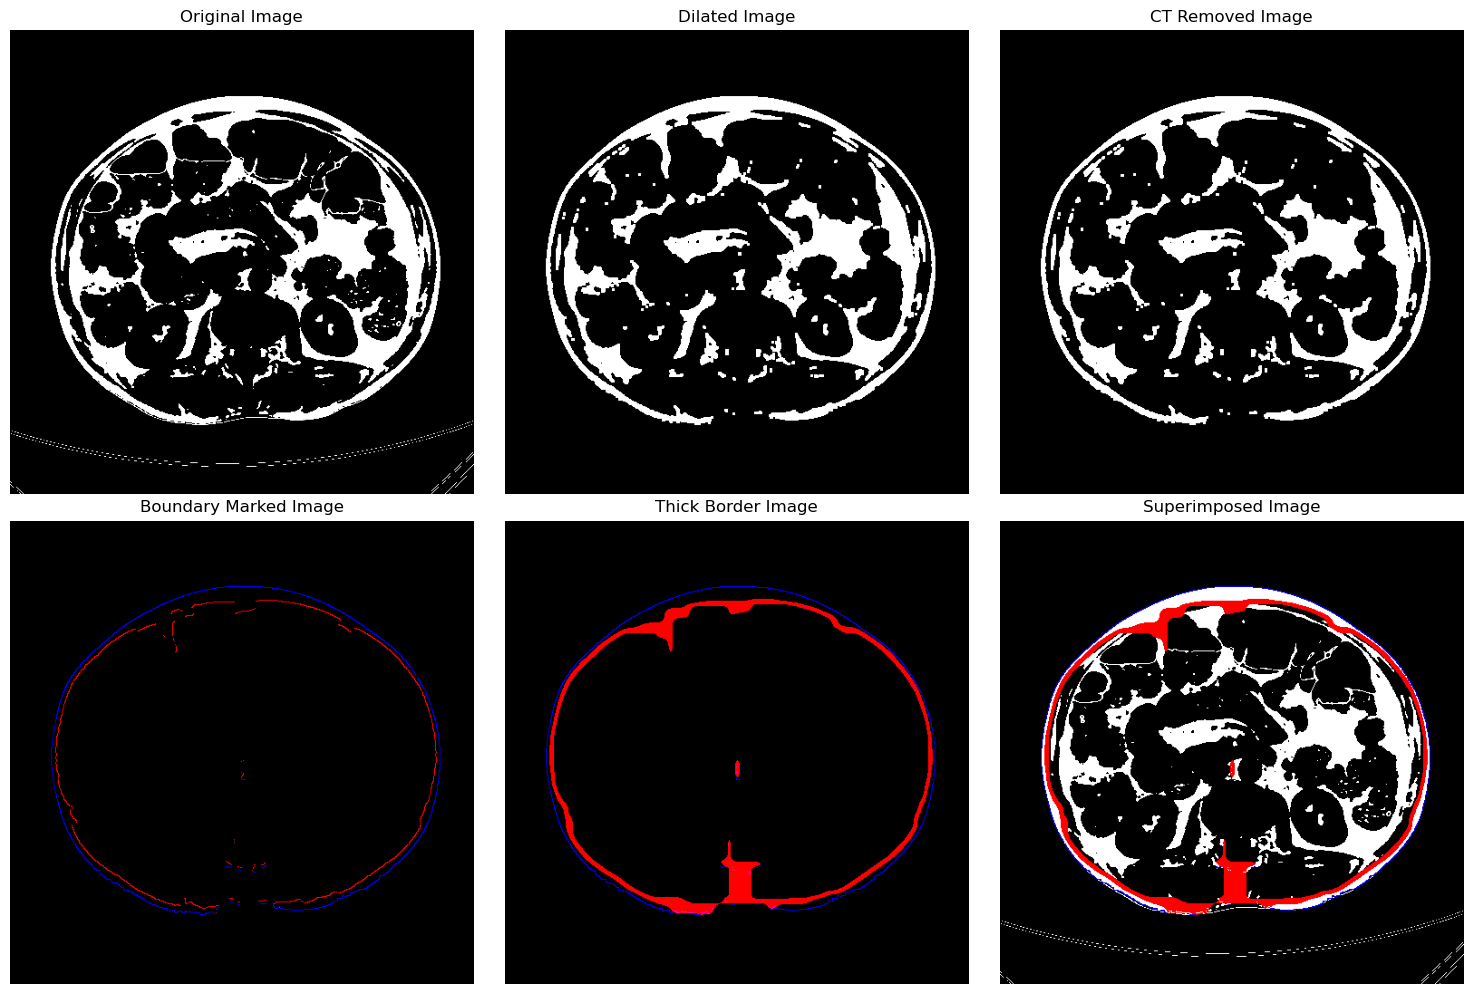

In [61]:


print("Image Path: ",img_path)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

thresh = removal_ct(img,"erosion-dilation")

img2 = convert_to_grayscale_if_rgb(thresh)
center = (img2.shape[1] // 2, img2.shape[0] // 2)
result_img_last = process_ray(img2, center, find_last_point)

subcut_area = compute_areas(img2, center, find_last_point)
print("Subcut-area : ",subcut_area)

total_area=compute_white_area(img2)
print("Total-area : ",total_area)

ratio = (total_area / subcut_area) - 1
print("Ratio : ",ratio)

cycles = 9

connected_image = result_img_last
kernel = np.ones((5, 5), np.uint8)  # Example: a 5x5 square kernel
blue_channel, green_channel, red_channel = cv2.split(connected_image)
dilated_red = cv2.dilate(red_channel, kernel, iterations=cycles-1)
blurred_image = cv2.GaussianBlur(dilated_red, (21, 21), 0)
eroded_red = cv2.erode(blurred_image, kernel, iterations=cycles-2)
connected_image = cv2.merge([blue_channel, green_channel, eroded_red])
(T, thresh2) = cv2.threshold(connected_image, 155, 255, cv2.THRESH_BINARY)


image_a= thresh2 # from above
image_b = cv2.imread(img_path)

if image_a.shape != image_b.shape:
    raise ValueError("Both images must be of the same size")

for idx,x in enumerate(image_b):
    for idy,y in enumerate(x):
        if image_a[idx][idy][0] == 0 and image_a[idx][idy][1] == 0 and image_a[idx][idy][2] == 255:
            image_b[idx][idy] = image_a[idx][idy]

        if image_a[idx][idy][0] == 255 and image_a[idx][idy][1] == 0 and image_a[idx][idy][2] == 0:
            image_b[idx][idy] = image_a[idx][idy]


fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the original image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

# Plot the dilated image
axs[0, 1].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Dilated Image')
axs[0, 1].axis('off')

# Plot the CT removed image
axs[0, 2].imshow(thresh, cmap='gray')
axs[0, 2].set_title("CT Removed Image")
axs[0, 2].axis('off')

# Plot the boundary marked image
axs[1, 0].imshow(cv2.cvtColor(result_img_last, cv2.COLOR_BGR2RGB), cmap='gray')
axs[1, 0].set_title("Boundary Marked Image")
axs[1, 0].axis('off')

# Plot the thick border image
axs[1, 1].imshow(cv2.cvtColor(thresh2, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Thick Border Image')
axs[1, 1].axis('off')

# Plot the superimposed image
axs[1, 2].imshow(cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB))
axs[1, 2].set_title('Superimposed Image')
axs[1, 2].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


Image Path:  ./Images/C.Vishnu/I1750.png


(-0.5, 511.5, 511.5, -0.5)

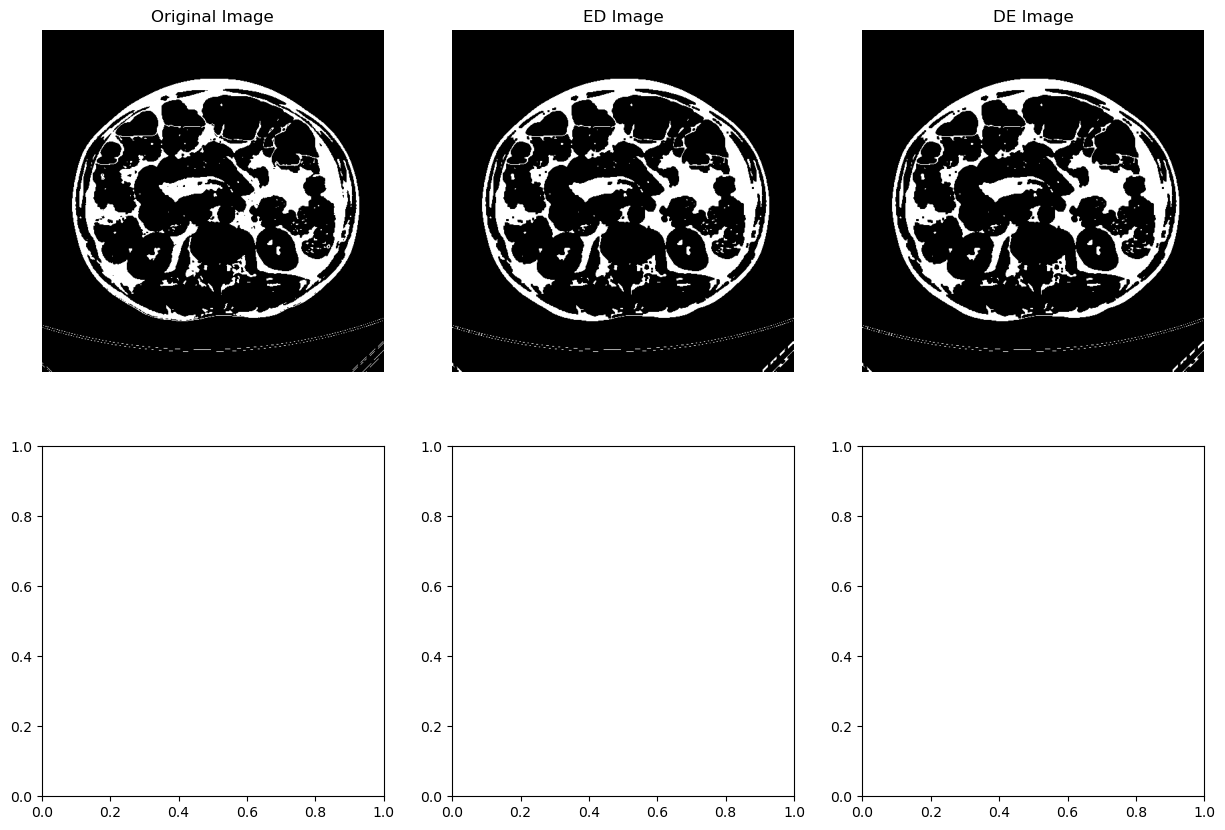

In [69]:

print("Image Path: ",img_path)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

thresh = removal_ct(img,"dilation-erosion")

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot the original image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')

# Plot the erosion-dilation image
axs[0, 1].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('ED Image')
axs[0, 1].axis('off')

thresh = removal_ct(img,"dilation-erosion")

# Plot the dilation-erosion image
axs[0, 2].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
axs[0, 2].set_title('DE Image')
axs[0, 2].axis('off')

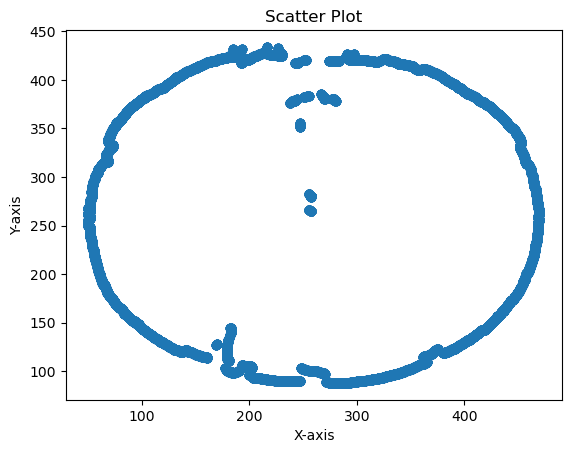

In [65]:
import matplotlib.pyplot as plt

def plot_points(x_values, y_values, title="Scatter Plot", x_label="X-axis", y_label="Y-axis"):
    plt.scatter(x_values, y_values)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

# Example usage
x_values = [a[0] for a in temp]
y_values = [a[1] for a in temp]

plot_points(x_values, y_values)


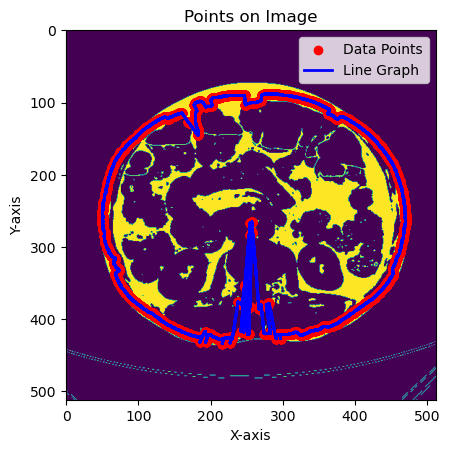

In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_points_on_image(x_values, y_values, image_path, title="Points on Image", x_label="X-axis", y_label="Y-axis"):
    # Load the image
    # img = mpimg.imread(image_path)

    # Plot the image
    plt.imshow(img)

    # Plot the points
    plt.scatter(x_values, y_values, color='red', marker='o', label='Data Points')

    # Connect the points with a line
    plt.plot(x_values, y_values, color='blue', linestyle='-', linewidth=2, label='Line Graph')

    # Adding labels and title
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Adding legend
    plt.legend()

    # Displaying the plot
    plt.show()

# Example usage
# x_values = [1, 2, 3, 4, 5]
# y_values = [2, 4, 6, 8, 10]
image_path = 'path/to/your/image.jpg'  # Replace with the actual path to your image

plot_points_on_image(x_values, y_values, image_path)


In [10]:
Image_list=[

'./Images/A.png',
'./Images/B.png',
'./Images/C.png',
]

ratios=[]

In [11]:
def routine(img_path):


    print("Image Path: ",img_path)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    thresh = removal_ct(img,"erosion-dilation")

    img2 = convert_to_grayscale_if_rgb(thresh)
    center = (img2.shape[1] // 2, img2.shape[0] // 2)
    result_img_last = process_ray(img2, center, find_last_point)

    subcut_area = compute_areas(img2, center, find_last_point)
    print("Subcut-area : ",subcut_area)

    total_area=compute_white_area(img2)
    print("Total-area : ",total_area)

    ratio = (total_area / subcut_area) - 1
    print("Ratio : ",ratio)

    ratios.append(ratio)

    # Connection Cell  : dilation -> blurring -> erosion (Gaussian mediated closing morphological operation)
    cycles = 9

    connected_image = result_img_last
    kernel = np.ones((5, 5), np.uint8)  # Example: a 5x5 square kernel
    blue_channel, green_channel, red_channel = cv2.split(connected_image)
    dilated_red = cv2.dilate(red_channel, kernel, iterations=cycles-1)
    blurred_image = cv2.GaussianBlur(dilated_red, (21, 21), 0)
    eroded_red = cv2.erode(blurred_image, kernel, iterations=cycles-2)
    connected_image = cv2.merge([blue_channel, green_channel, eroded_red])
    (T, thresh2) = cv2.threshold(connected_image, 155, 255, cv2.THRESH_BINARY)


    image_a= thresh2 # from above
    image_b = cv2.imread(img_path)

    if image_a.shape != image_b.shape:
        raise ValueError("Both images must be of the same size")

    for idx,x in enumerate(image_b):
        for idy,y in enumerate(x):
            if image_a[idx][idy][0] == 0 and image_a[idx][idy][1] == 0 and image_a[idx][idy][2] == 255:
                image_b[idx][idy] = image_a[idx][idy]

            if image_a[idx][idy][0] == 255 and image_a[idx][idy][1] == 0 and image_a[idx][idy][2] == 0:
                image_b[idx][idy] = image_a[idx][idy]



    # -------------------------------------------------------------------------------------------------------

    # Assuming you have the images named img, thresh, thresh2, result_img_last, and image_b

    # Create a 2x3 subplot grid
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Plot the original image
    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    # Plot the dilated image
    axs[0, 1].imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
    axs[0, 1].set_title('Dilated Image')
    axs[0, 1].axis('off')

    # Plot the CT removed image
    axs[0, 2].imshow(thresh, cmap='gray')
    axs[0, 2].set_title("CT Removed Image")
    axs[0, 2].axis('off')

    # Plot the boundary marked image
    axs[1, 0].imshow(cv2.cvtColor(result_img_last, cv2.COLOR_BGR2RGB), cmap='gray')
    axs[1, 0].set_title("Boundary Marked Image")
    axs[1, 0].axis('off')

    # Plot the thick border image
    axs[1, 1].imshow(cv2.cvtColor(thresh2, cv2.COLOR_BGR2RGB))
    axs[1, 1].set_title('Thick Border Image')
    axs[1, 1].axis('off')

    # Plot the superimposed image
    axs[1, 2].imshow(cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB))
    axs[1, 2].set_title('Superimposed Image')
    axs[1, 2].axis('off')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()


Image Path:  ./Images/C.DineshKumar/I4860.png
flag :  6.283185307190819
Subcut-area :  29874.399816990423
Total-area :  71308
Ratio :  1.386926613984898


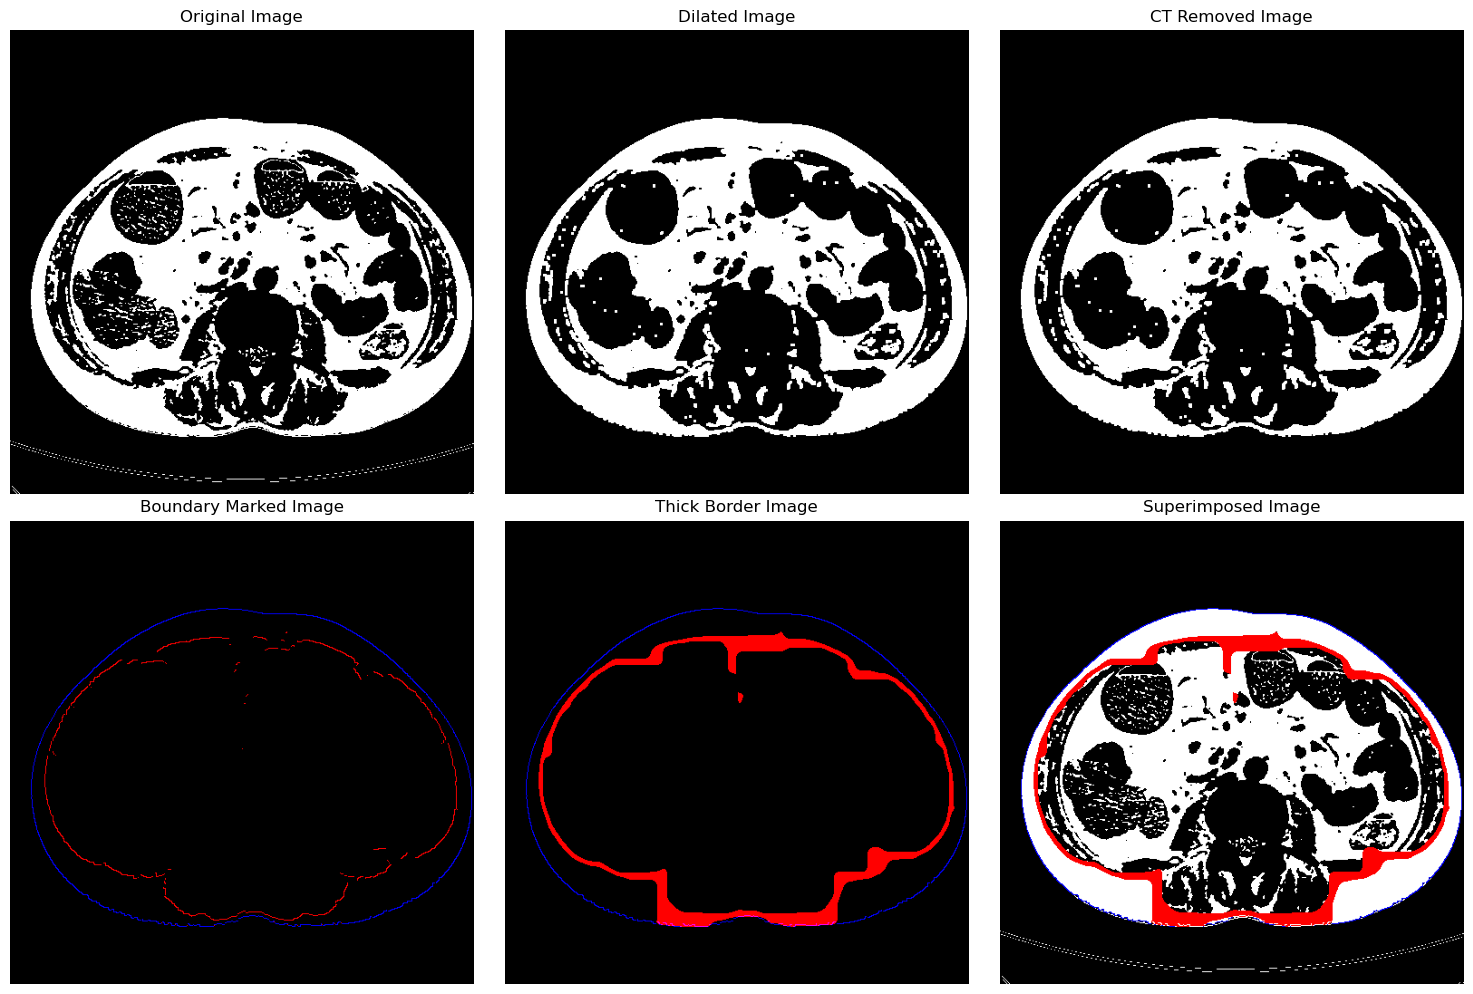

Image Path:  ./Images/C.KamleshSingh/I4010.png
flag :  6.283185307190819
Subcut-area :  34784.50501829556
Total-area :  59755
Ratio :  0.7178625933751464


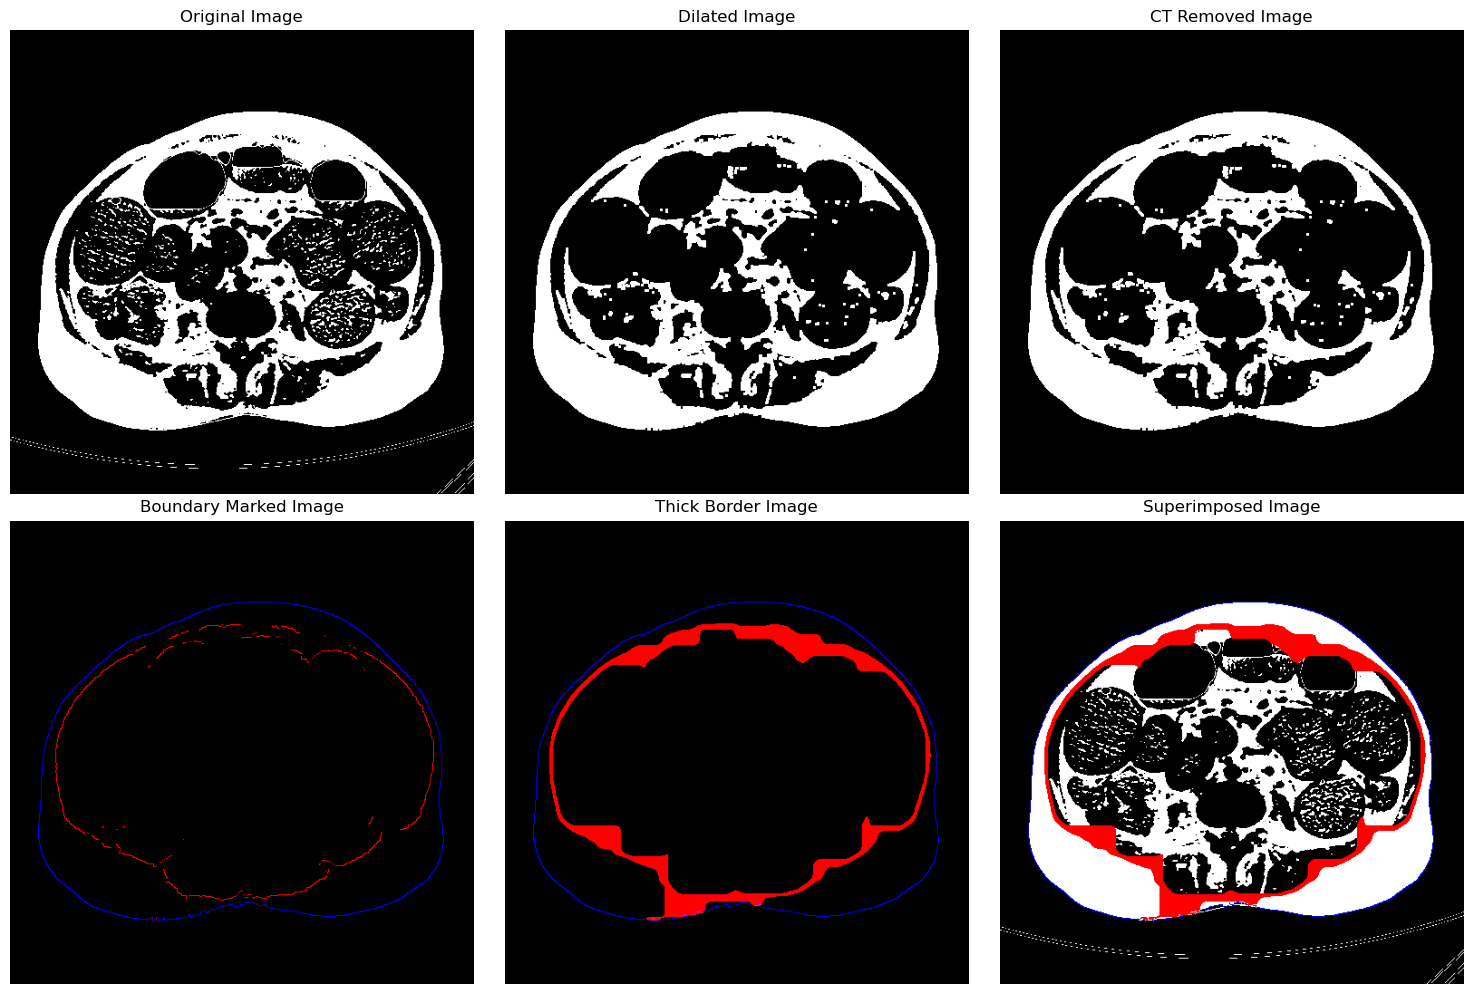

Image Path:  ./Images/C.RajaRamGupta/I4430.png
flag :  6.283185307190819
Subcut-area :  9017.28852265626
Total-area :  20046
Ratio :  1.2230629473187764


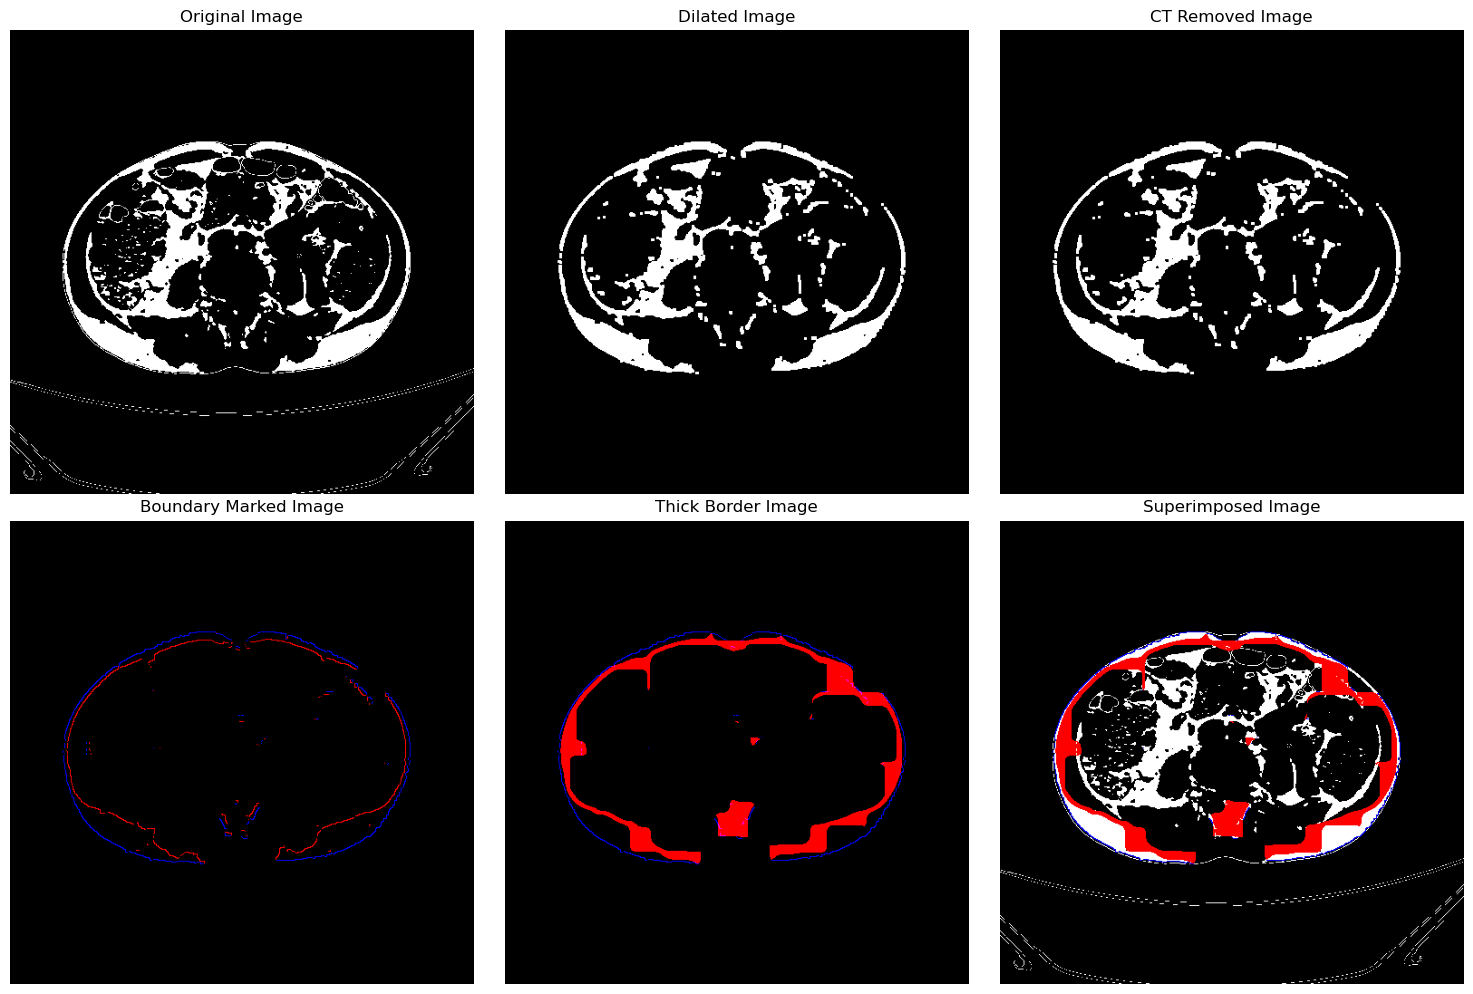

Image Path:  ./Images/C.SairaBano/I2090.png
flag :  6.283185307190819
Subcut-area :  71614.9781863583
Total-area :  103504
Ratio :  0.4452842494856213


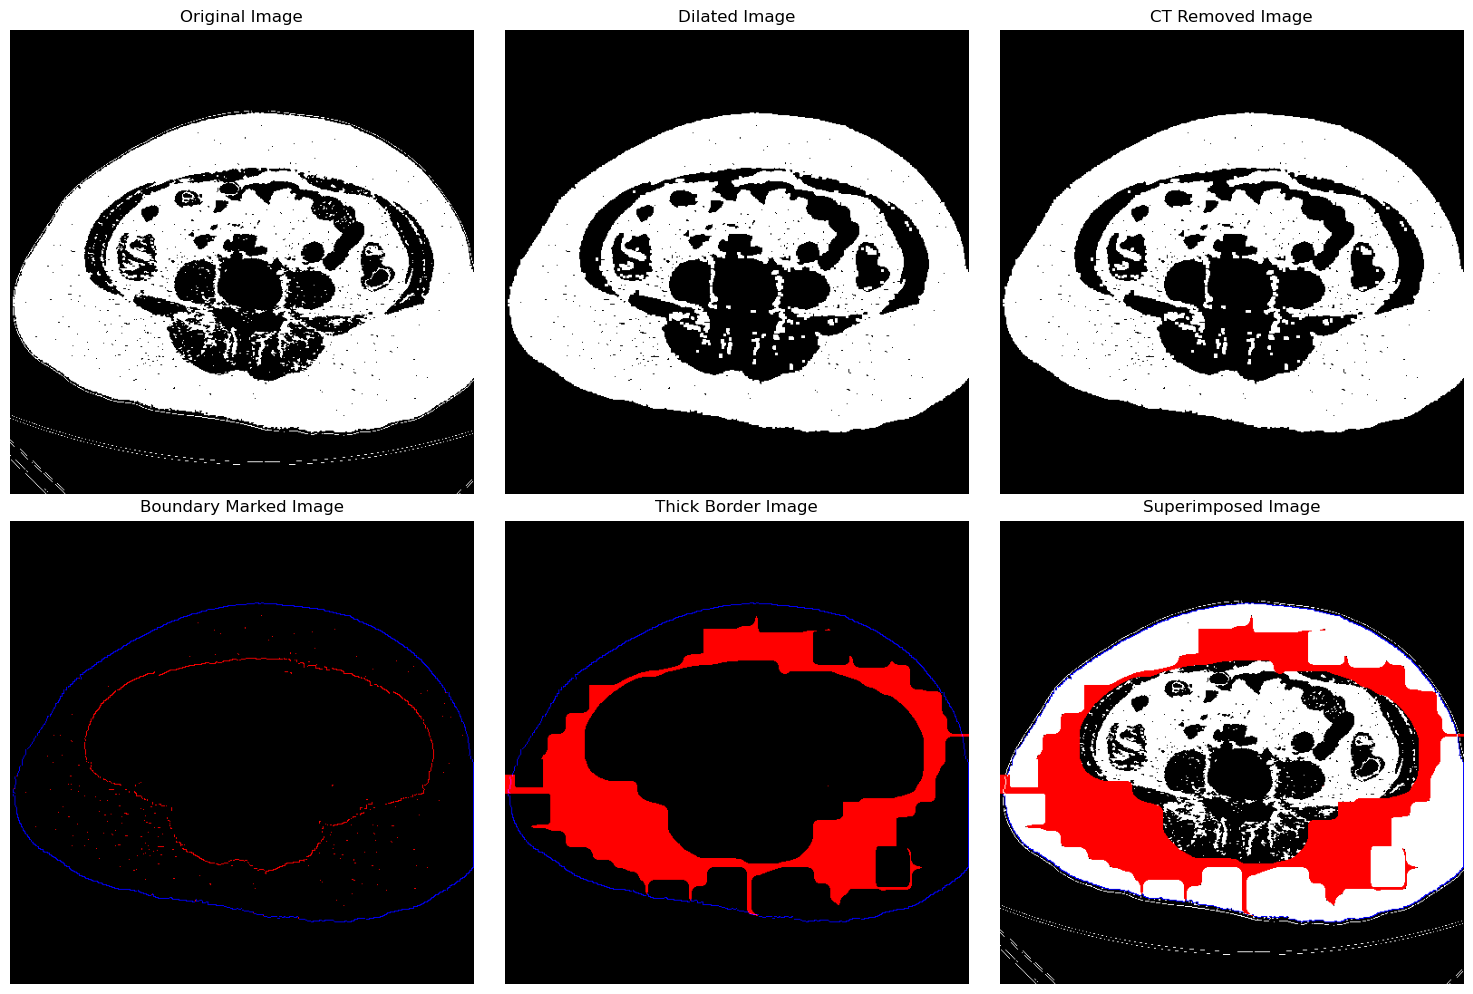

Image Path:  ./Images/C.SarvottamKumar/I2450.png
flag :  6.283185307190819
Subcut-area :  20918.65793057955
Total-area :  33084
Ratio :  0.5815546154916933


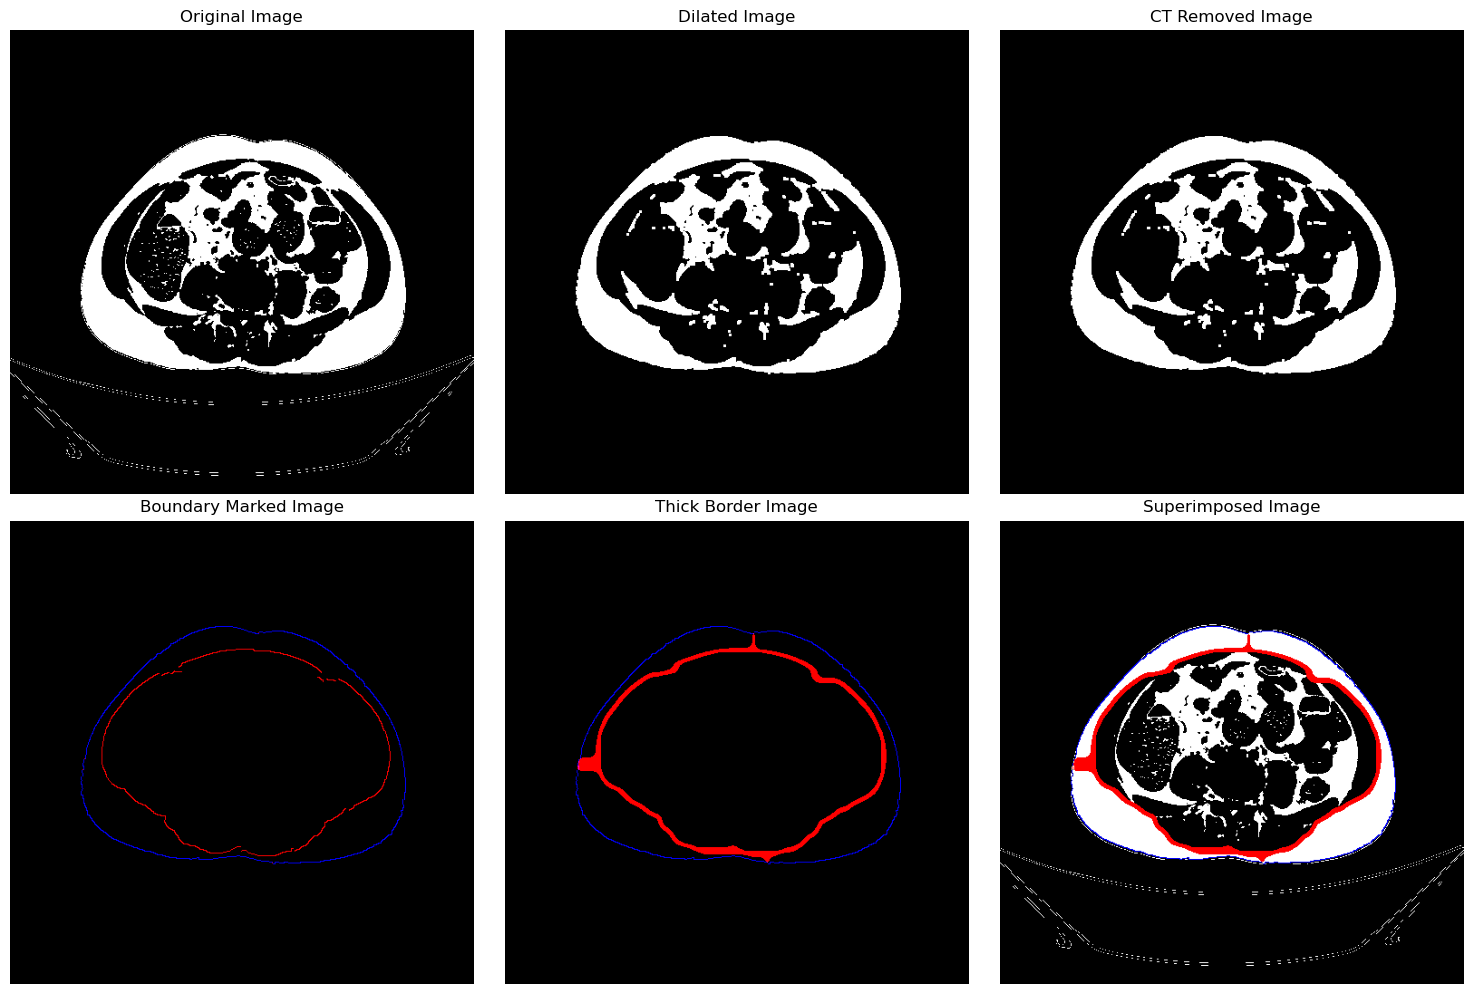

Image Path:  ./Images/C.ShivamSingh/I5700.png
flag :  6.283185307190819
Subcut-area :  44009.06653036185
Total-area :  66349
Ratio :  0.5076211615219293


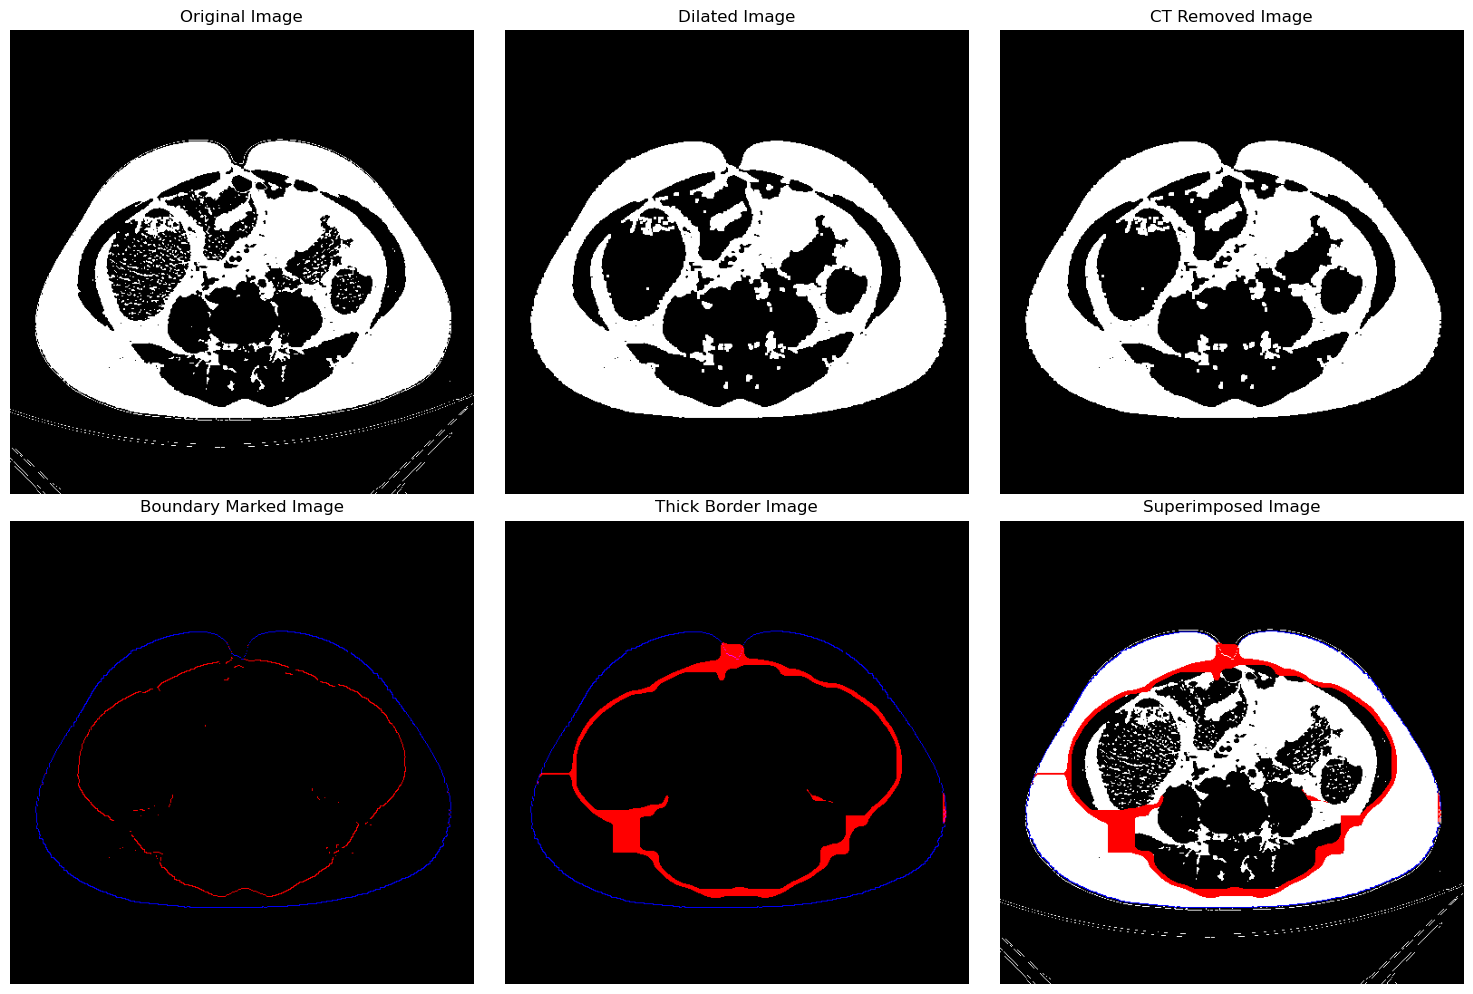

Image Path:  ./Images/C.SudhaChaturvedi/I1840.png
flag :  6.283185307190819
Subcut-area :  31114.179659479745
Total-area :  54481
Ratio :  0.751002295295963


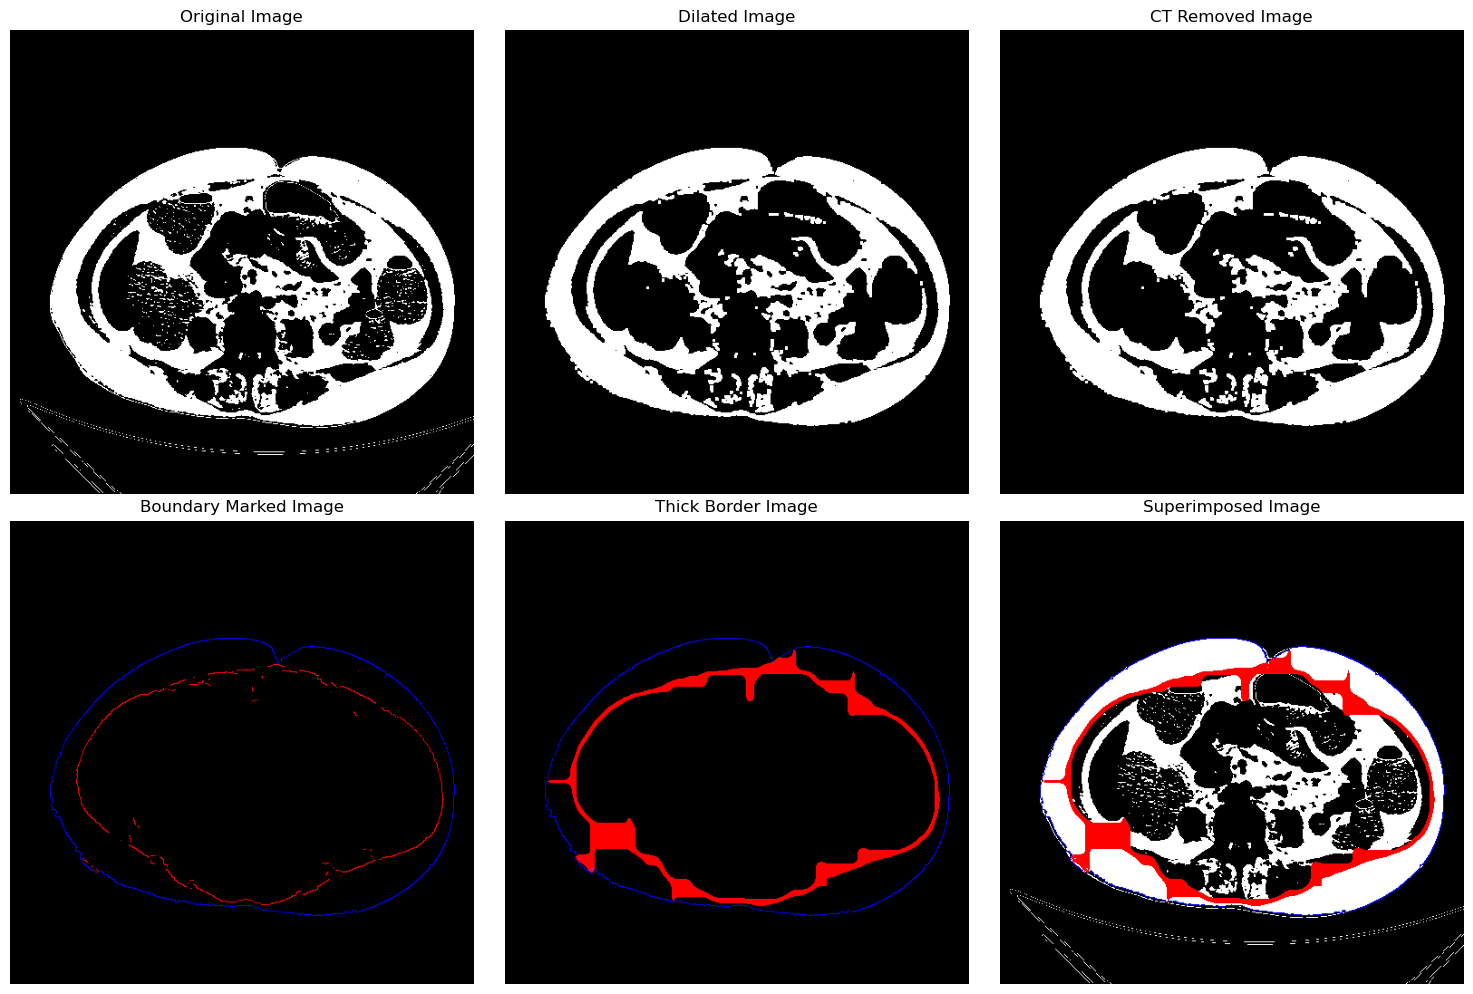

Image Path:  ./Images/C.VishnuPrasad/I1750.png
OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgproc/src/morph.dispatch.cpp:1010: error: (-215:Assertion failed) !src.empty() in function 'erode'

Image Path:  ./Images/T.Angelina/I3800.png


[ WARN:0@785.409] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./Images/C.VishnuPrasad/I1750.png'): can't open/read file: check file path/integrity


flag :  6.283185307190819
Subcut-area :  49696.82342571029
Total-area :  77205
Ratio :  0.5535198163200619


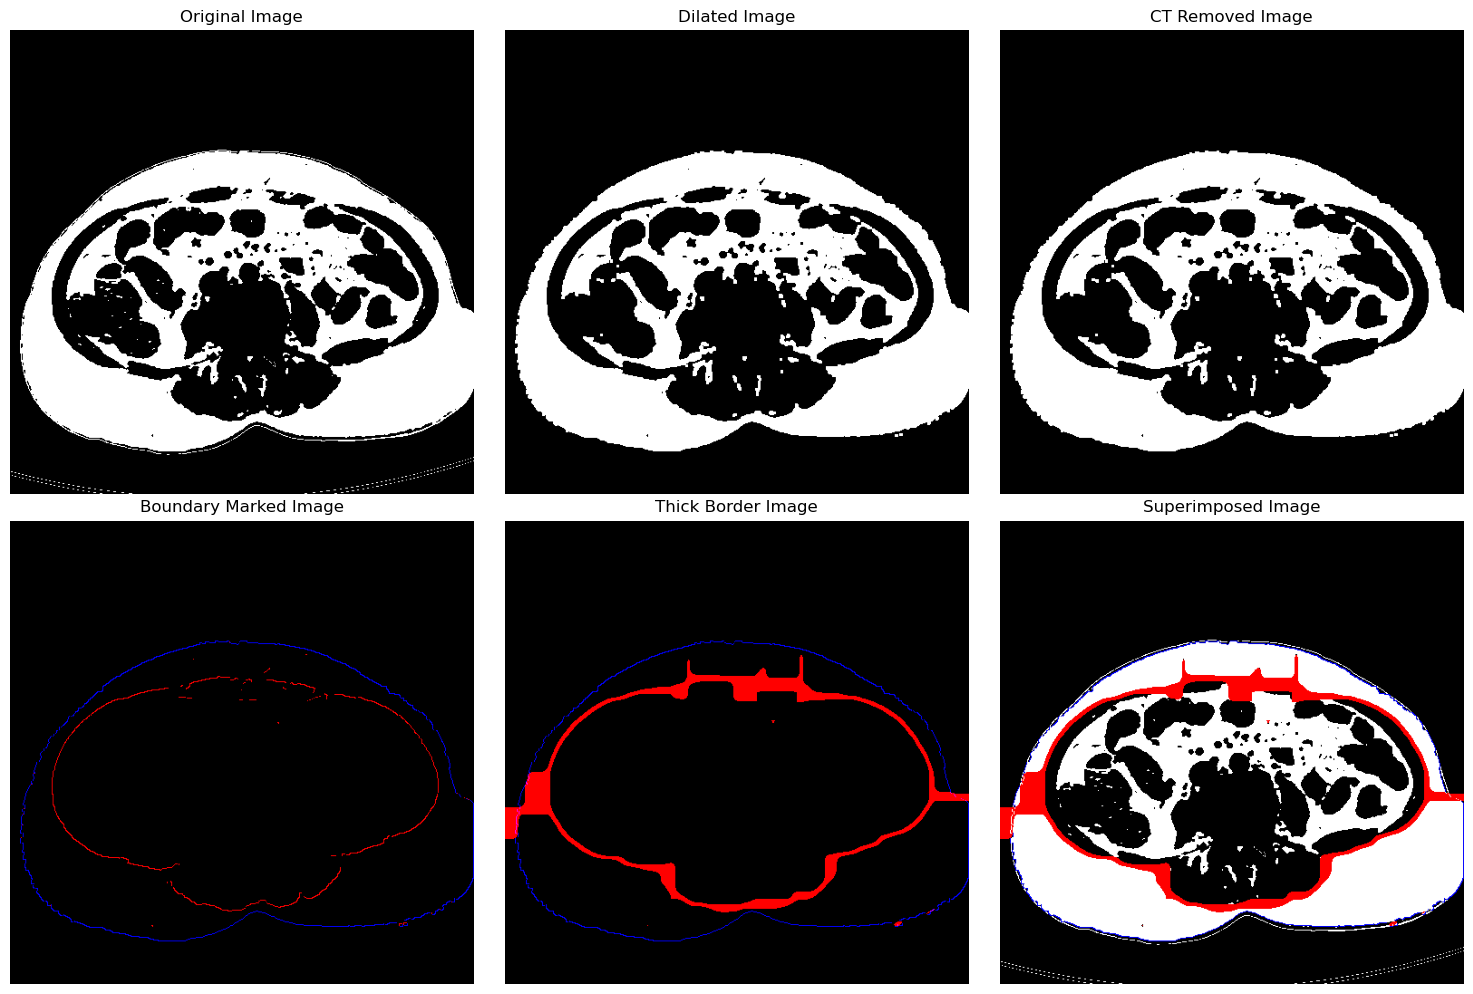

Image Path:  ./Images/T.ArpitaGupta/I7480.png
flag :  6.283185307190819
Subcut-area :  35193.72246326886
Total-area :  48782
Ratio :  0.38609946847518084


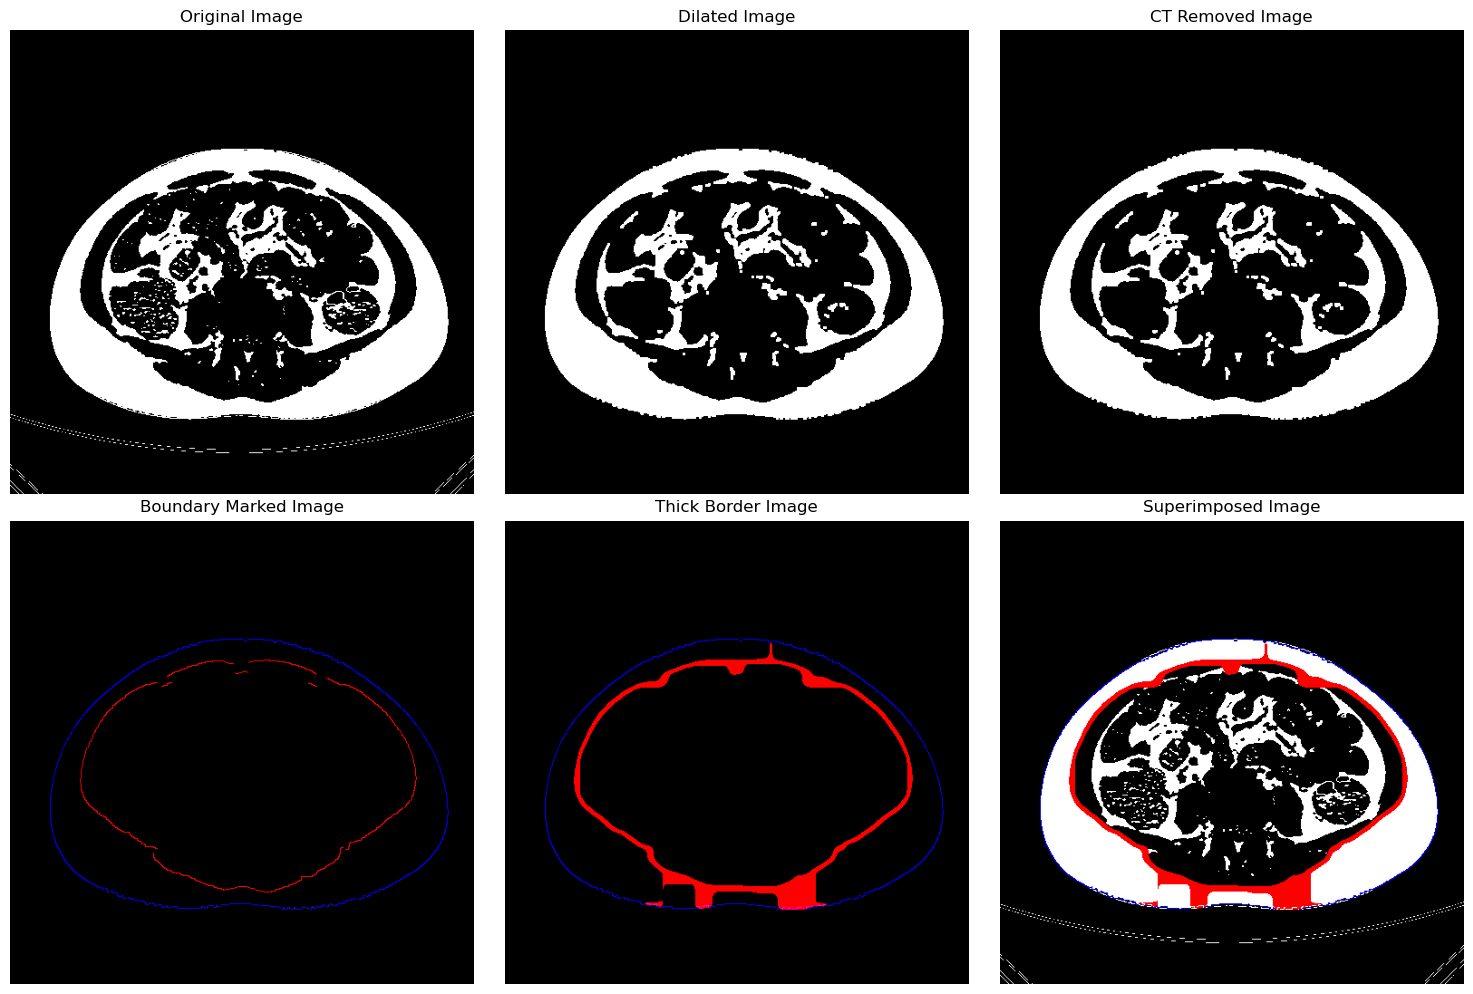

Image Path:  ./Images/T.ManshiBisht/I3710.png
flag :  6.283185307190819
Subcut-area :  30501.78381116187
Total-area :  51880
Ratio :  0.7008841293083636


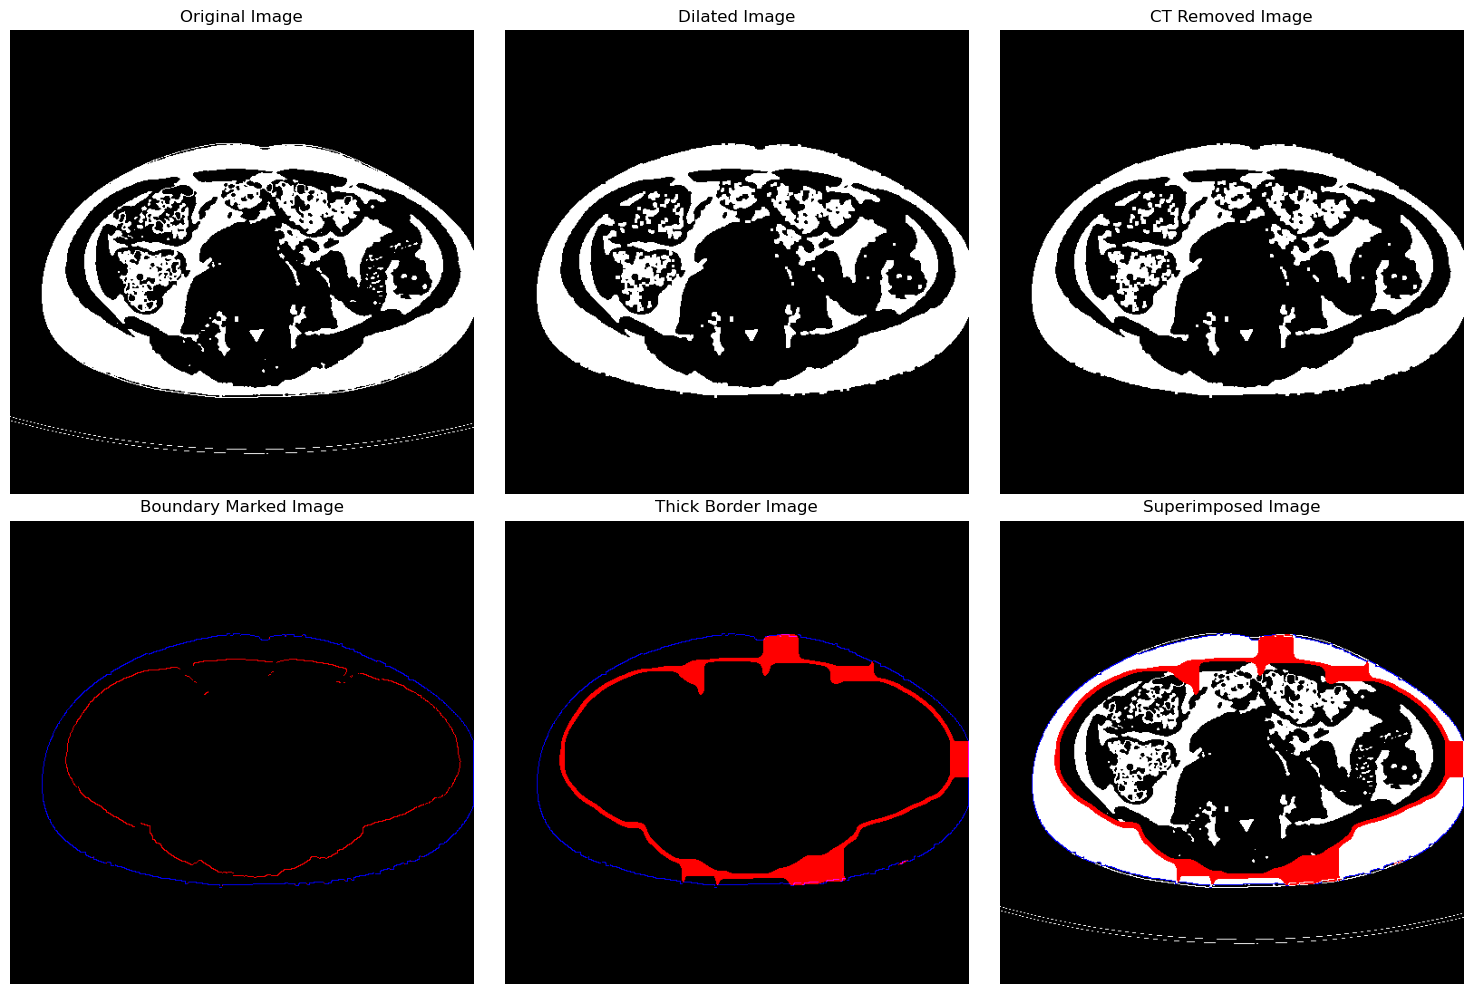

Image Path:  ./Images/T.ShivendraSahai/I7780.png
flag :  6.283185307190819
Subcut-area :  36919.05307819391
Total-area :  54325
Ratio :  0.47146244203340215


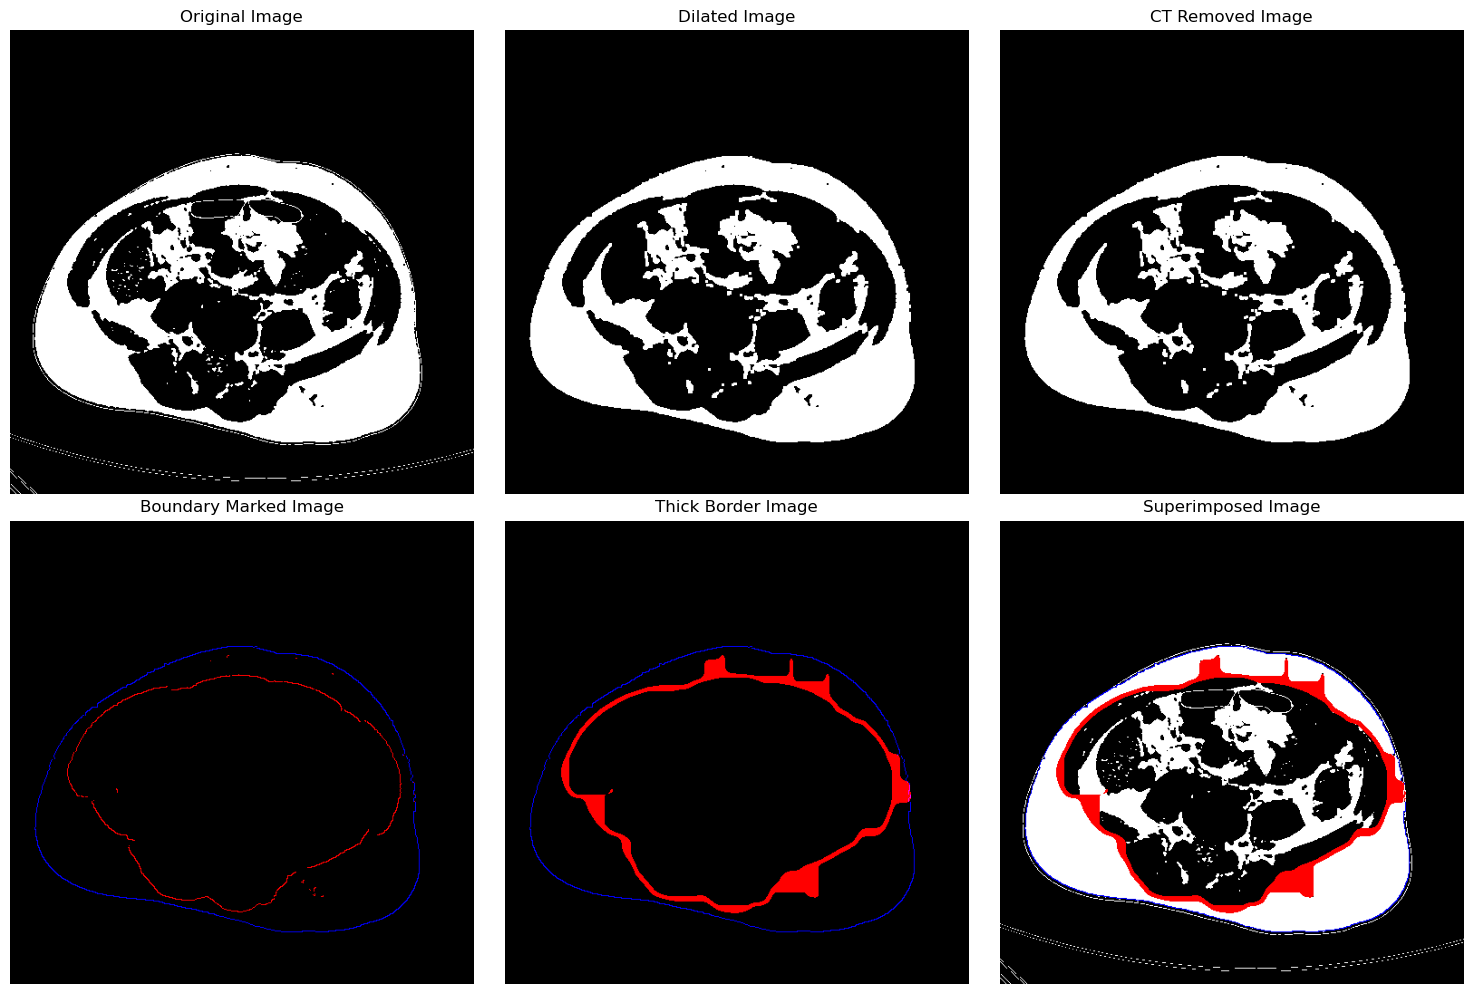

Image Path:  ./Images/T.Talha/I3840.png
flag :  6.283185307190819
Subcut-area :  14984.70672353756
Total-area :  24688
Ratio :  0.647546425531357


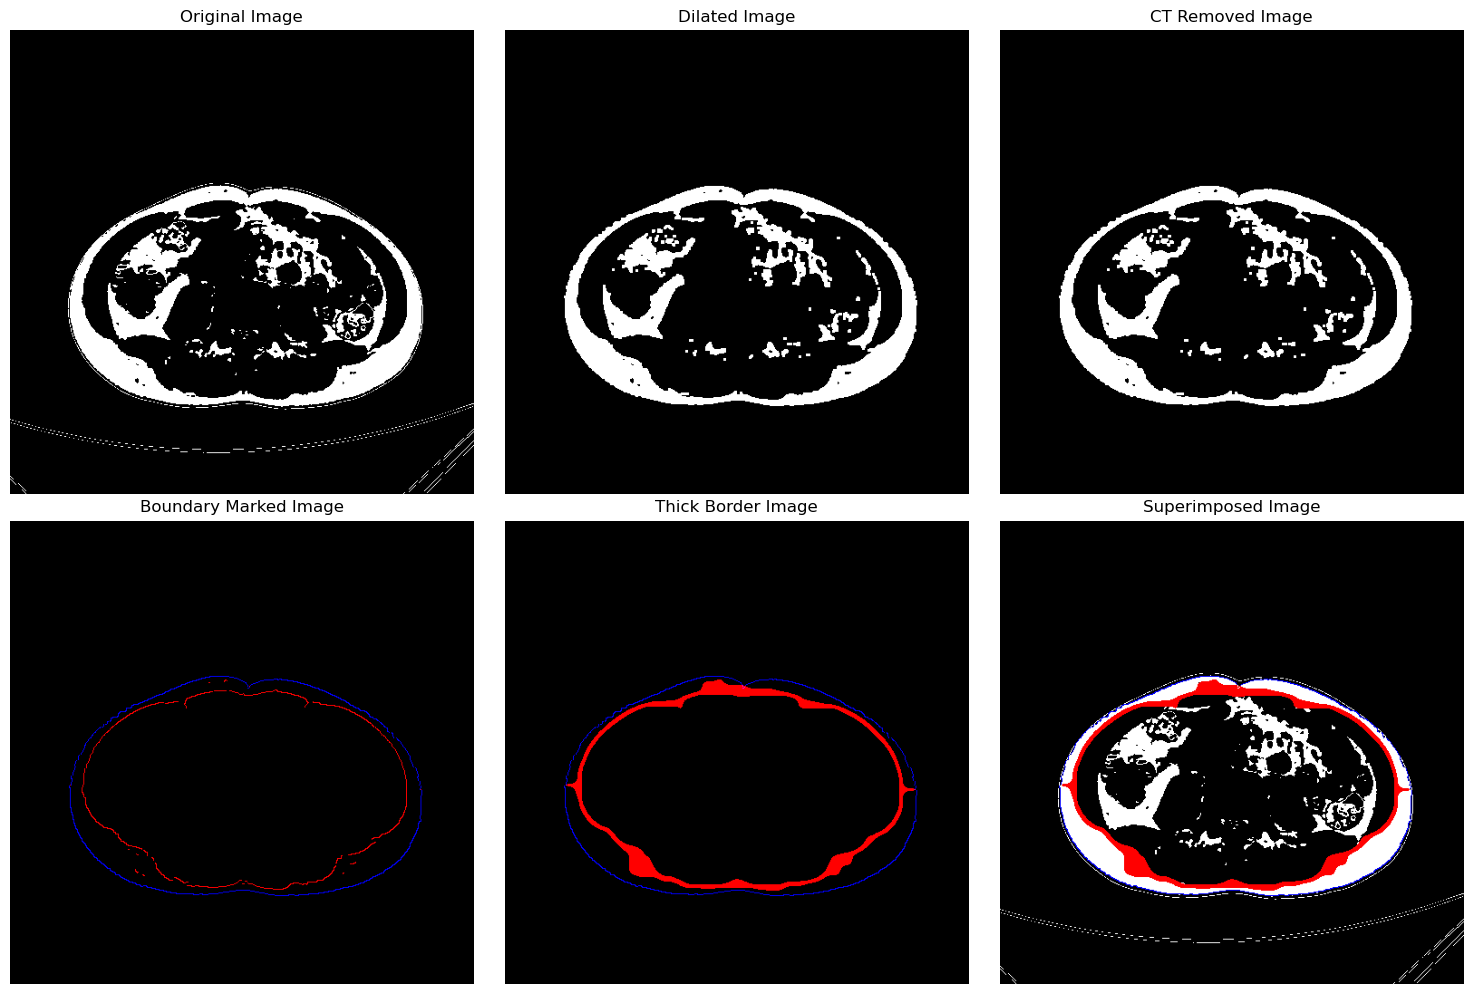

Image Path:  ./Images/N.RabiyaKhatoon/I4550.png
flag :  6.283185307190819
Subcut-area :  33966.22236469704
Total-area :  56048
Ratio :  0.6501099061947426


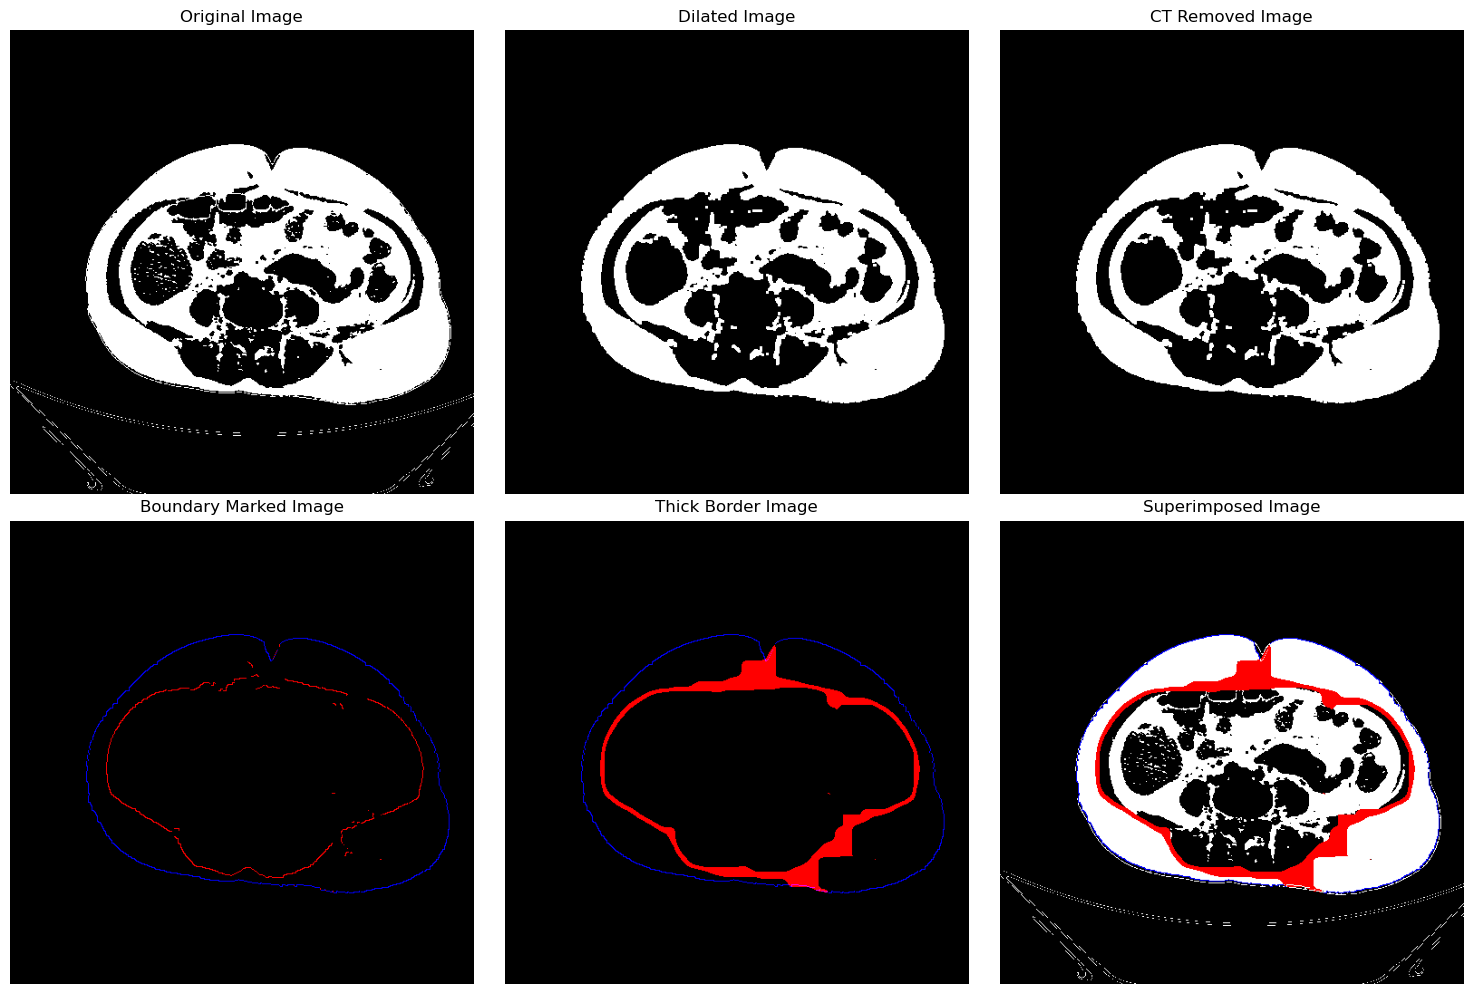

Image Path:  ./Images/N.RadheyShyamKushwaha/I4570.png
flag :  6.283185307190819
Subcut-area :  47220.12215371228
Total-area :  77450
Ratio :  0.6401905896787512


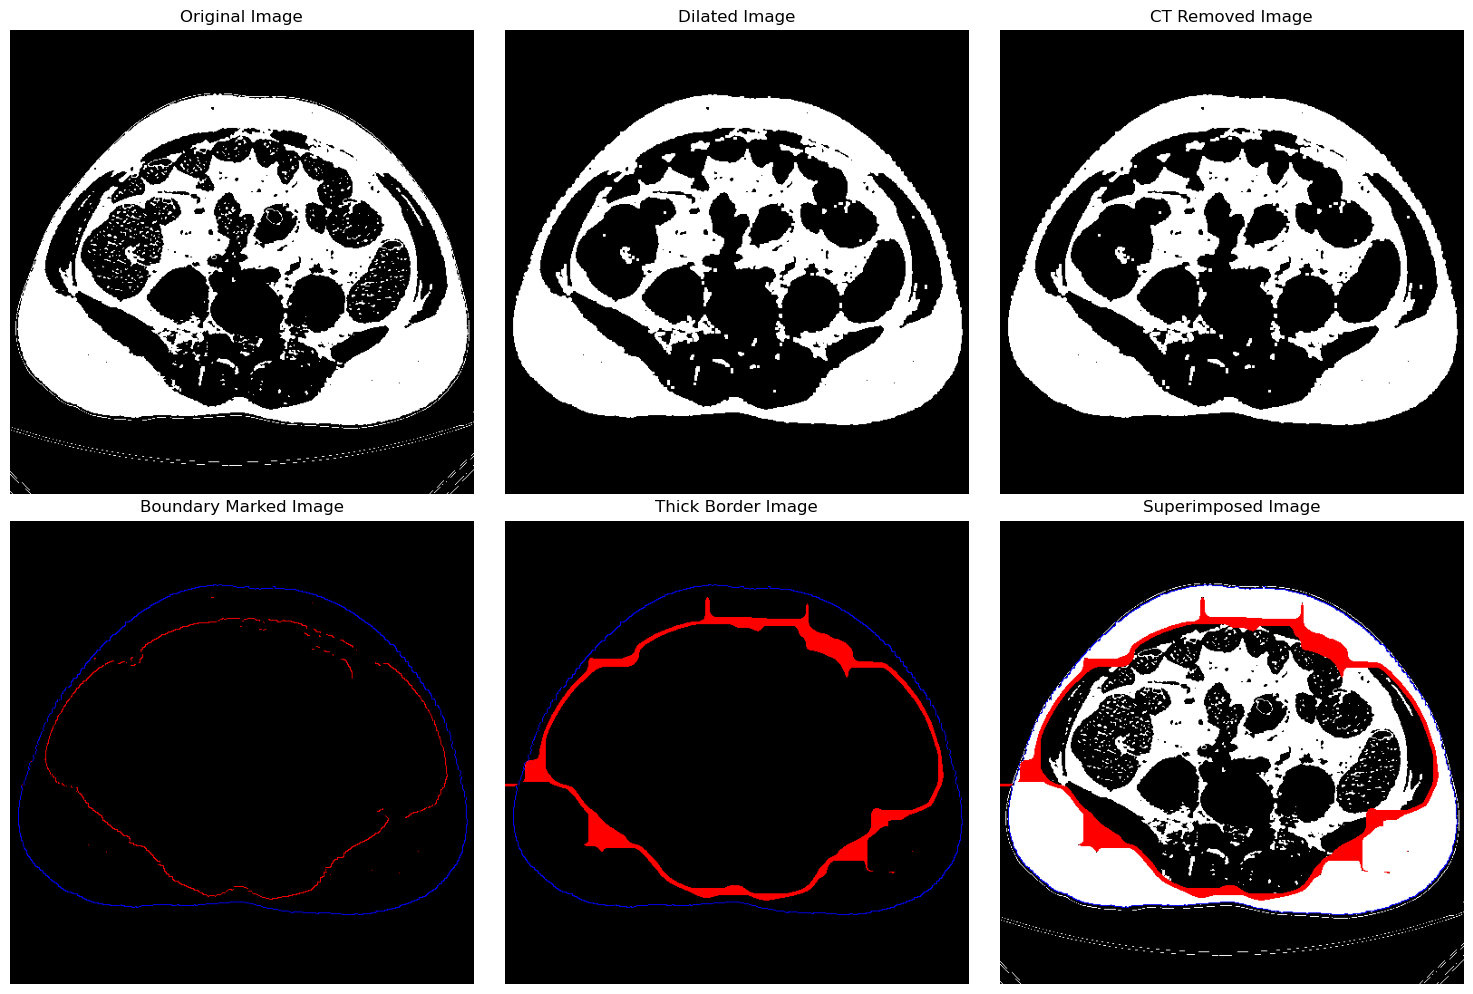

Image Path:  ./Images/N.RajKumariDev/I4140.png
flag :  6.283185307190819
Subcut-area :  48549.57221351574
Total-area :  85585
Ratio :  0.7628373659732051


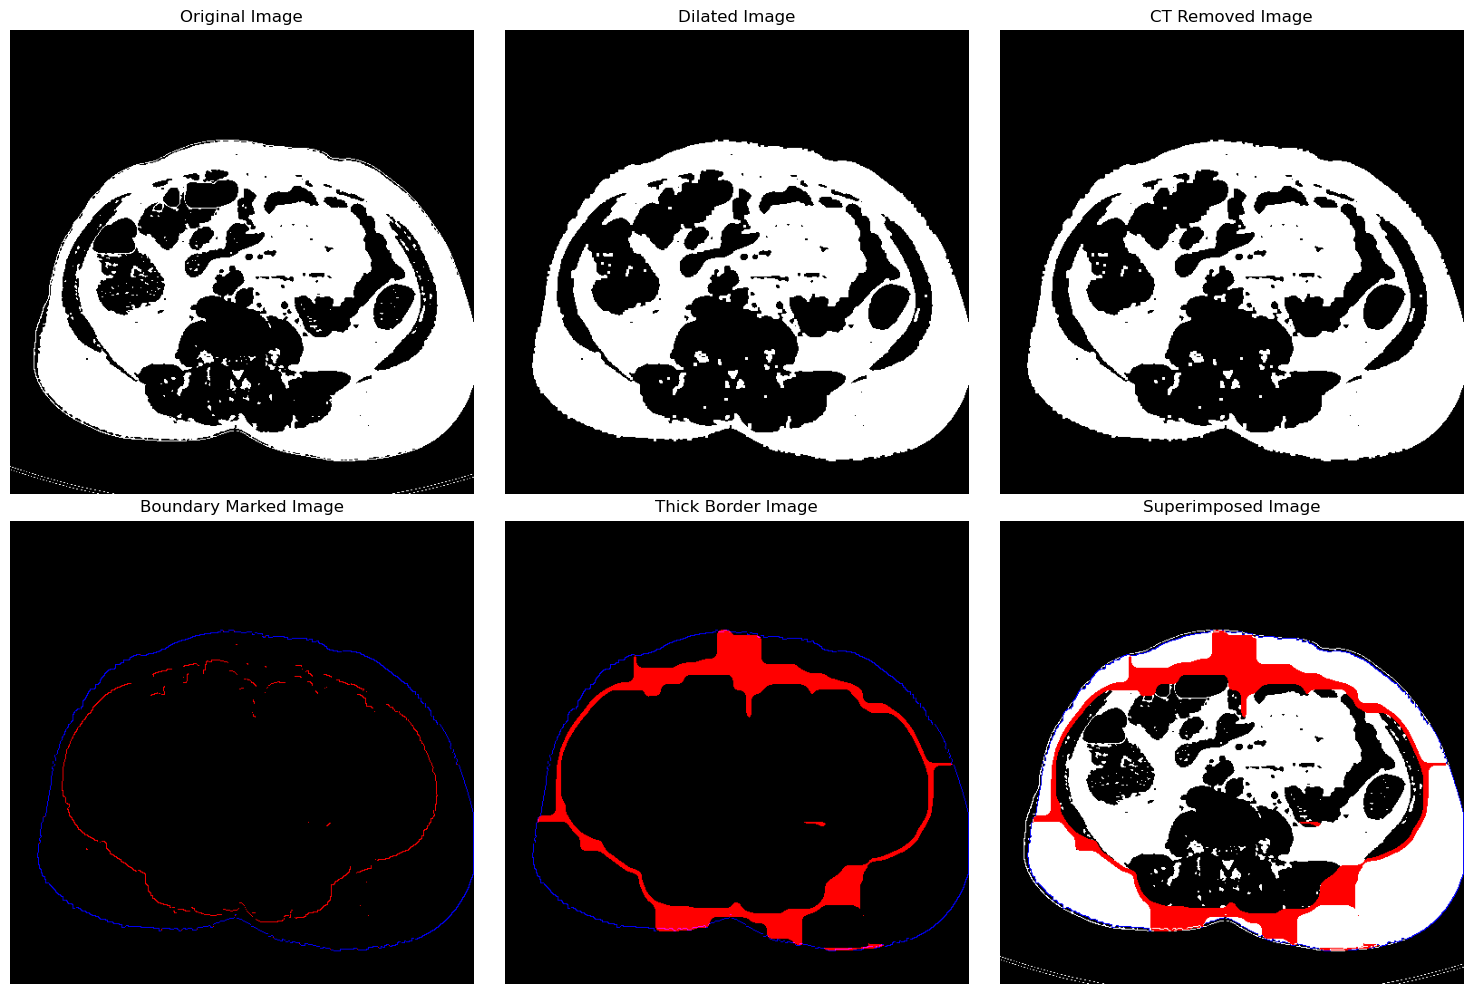

Image Path:  ./Images/N.VidyawatiYadav/I4130.png
flag :  6.283185307190819
Subcut-area :  37661.03822721002
Total-area :  62892
Ratio :  0.6699486514570028


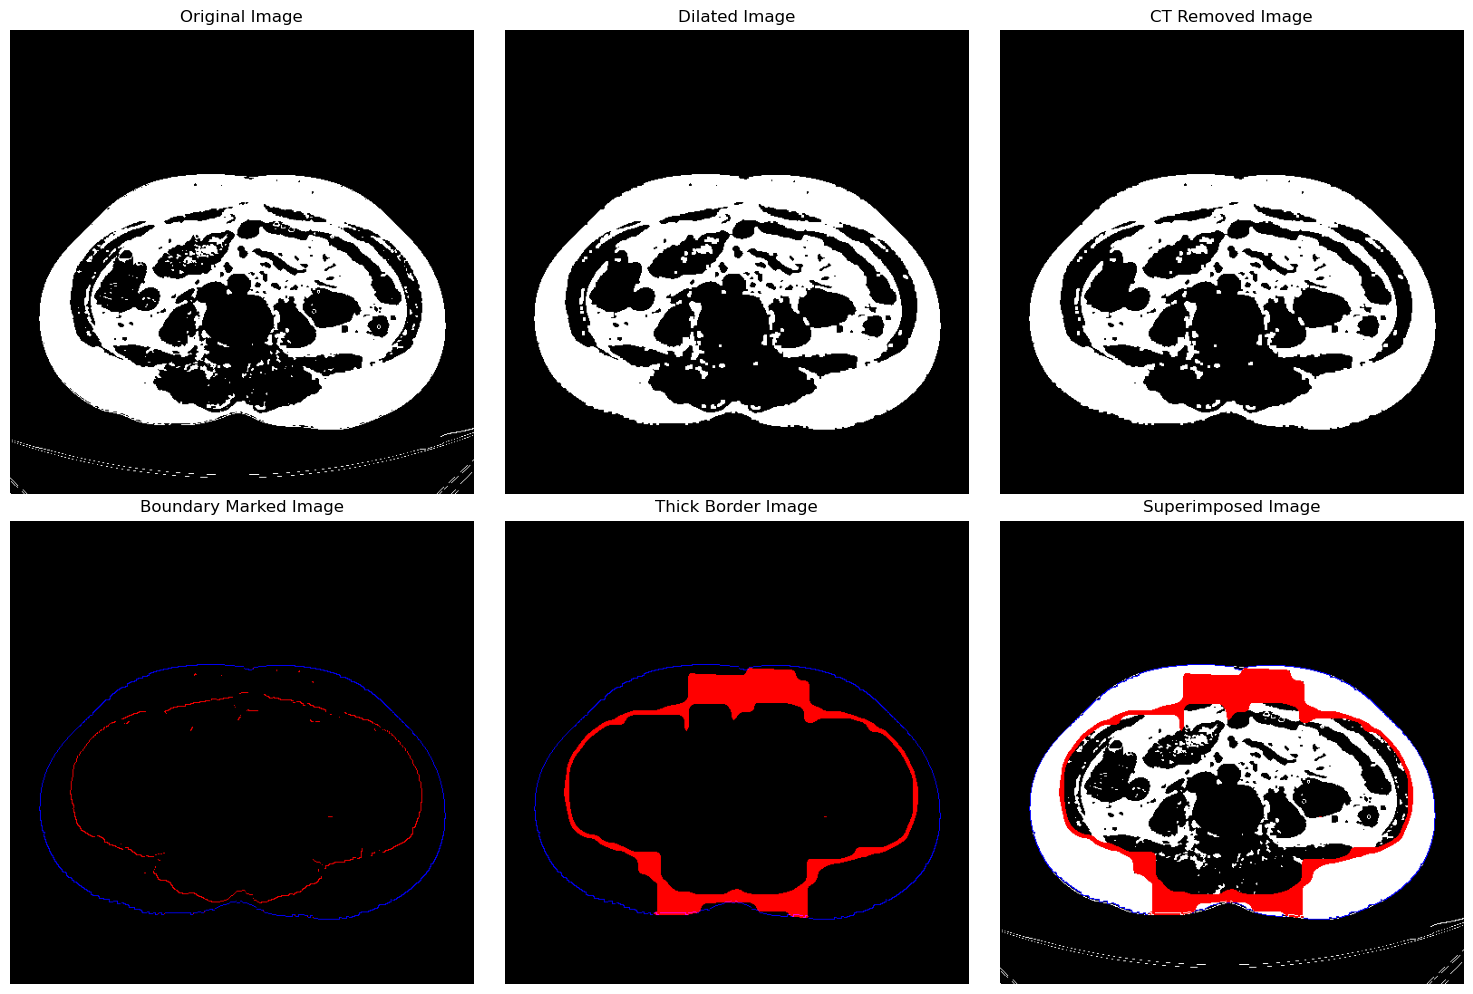

Data has been written to output.csv.


In [12]:
import csv

ratios = []

for i in Image_list:
    try:
        routine(i)
    except Exception as e:
        print(e)
        ratios.append(-1)

try:
    with open('output.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['FileName', 'Ratio',''])

        for filename, ratio in zip(Image_list, ratios):
            writer.writerow([filename, ratio])

    print("Data has been written to output.csv.")
except Exception as e:
    print(e)

with open('numbers2.txt', 'w') as file:
    for number in ratios:
        file.write(str(number) + '\n')
